In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from frechetdist import frdist
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

- Load in datasets:

In [2]:
confirmed = pd.read_csv('time_series_covid19_confirmed_global.txt')
death = pd.read_csv('time_series_covid19_deaths_global.txt')
rec = pd.read_csv('time_series_covid19_recovered_global.txt')

- No null values in the raw datasets, so we do not need to worry about these.

- First, I will define all of the functions I created. I will also give a brief overview of what they do, and my rationale for setting up my data processing the way I have. As such, going sequentially through the function descriptions gives a good overview of my methodology for dealing with the data. I then flesh out my approach to data processing and modelling in more detail later on.

**DEFINE FUNCTIONS:**

**fileClean**: a generic function to drop unnecessary columns/rows, and create 2 dataframes; one with just the numeric values, and another with the date of each region's first confirmed case. This first confirmed case is used later to set all infection curves as starting on the same day 0 (daysSinceFirst function below).

In [3]:
def fileClean(dataframe):
    #Drop columns etc.:
    df=dataframe
    df=df[df['Province/State'] != 'Diamond Princess']
    df=df[df['Province/State'] != 'Recovered']
    df=df[df['Province/State'] != 'Grand Princess']
    df=df[df['Country/Region'] != 'MS Zaandam']
    df=df.reset_index()
    df=df.drop('index', axis=1)
    
    #create single region identifier, and establish date of first case:
    df['Province/State'] = df['Province/State'].replace(np.nan, '...', regex=True)
    df['region']=df['Country/Region'] +' - '+ df['Province/State']
    drop=['Province/State', 'Country/Region', 'Lat', 'Long']
    df=df.drop(drop, 1)
    df['first case']=df.iloc[:,:-1][df.iloc[:,:-1] > 0].idxmin(axis=1)
    
    #Make a separate region database with date of first confirmed case, and allow main dataframe to be entirely numeric:
    df2=pd.DataFrame(df['region'])
    df2=df2.join(df['first case'])
    drop=['first case','region']
    df=df.drop(drop, axis=1)
    
    return(df,df2)

**getCanada**: This function adds all the values for all provinces together in order to predict the canada-wide values going forward. Due to the ways in which both the confirmed cases and deaths/recovered had to be processed ahead of analysis, there was some inconsistent indexing going on for the provinces across datasets. Given enough time, I could have included some if statements within a single function, but I was under the gun, and just duplicating the function worked well enough. There are some other duplicated functions further down for this same reason. Conf=confirmed cases dataset, Death=death dataset.

In [4]:
def getCanadaConf(df, reg):

    provinces=[35,36,37,38,39,40,41,42,43,44]
    temp=df.query('index in @provinces').T
    temp[999]=temp.sum(axis=1)
    temp=temp.T
    canada=temp.loc[[999]]
    temp=df.query('index not in @provinces')
    tempregion=reg.query('index not in @provinces')
    temp=temp.append(canada)
    row=pd.DataFrame({"first case":['3/9/20'], 
                    "region":['Canada']})
    tempregion=tempregion.append(row)
    tempregion=tempregion.reset_index()
    tempregion=tempregion.drop('index', axis=1)
    temp=temp.reset_index()
    temp=temp.drop('index', axis=1)
    nindex=len(tempregion)-1
    
    return(temp, tempregion, nindex) #gives region and value dataframe for Canada overall, and Canada's new index

In [5]:
def getCanadaDeath(df, reg):

    provinces=[32,33,34,35,36,37,38,39,40]
    temp=df.query('index in @provinces').T
    temp[999]=temp.sum(axis=1)
    temp=temp.T
    canada=temp.loc[[999]]
    temp=df.query('index not in @provinces')
    tempregion=reg.query('index not in @provinces')
    temp=temp.append(canada)
    row=pd.DataFrame({"first case":['3/9/20'], 
                    "region":['Canada']})
    tempregion=tempregion.append(row)
    tempregion=tempregion.reset_index()
    tempregion=tempregion.drop('index', axis=1)
    temp=temp.reset_index()
    temp=temp.drop('index', axis=1)
    nindex=len(tempregion)-1
    
    return(temp, tempregion, nindex) #gives region and value dataframe for Canada overall, and Canada's new index

**daysSinceFirst**: This 'resets' all countries by removing any leading days with zeroes. Thus, in the dataframe, all countries first day of infection occurs in the same column (0), and the values in the column headers now denote "days since first infection". This allows me to cluster by trajectories, as having all infections start at the same place allows curves to be comparable once scaled. Through clustering, I can remove outliers. This also means that many regions have infections that extend past the most recent day of infection for Canada. This lets me train on "future" values to predict the next 3 days for canadian provinces.

In [6]:
def daysSinceFirst(dataframe, region):
    for i in range(len(dataframe)):
        temp=dataframe.loc[[i]]
        fh=region.at[i, 'first case']
        v=temp.columns.get_loc(fh)
        nozero=temp.iloc[:,v:]
        cols=[i for i in range(len(nozero.columns))]
        nozero.columns = cols
        if i == 0:
            df=nozero
        else:
            df=df.append(nozero)
    
    return(df)

**getProvince**: Gets a dataframe with only regions who have had infections for at least as long as your chosen province +3 days. This gives me my "future" values to train my model on; only regions who are ahead of our chosen province in their infection will be used to predict the future values for our chosen province.

In [7]:
def getProvince(dataframe, index): #index of whichever province you want
       
    prov=dataframe.loc[[index]] 
    null=prov.columns[prov.isna().any()].tolist()
    notnull=null[0]+3   #gets countries who have had the virus for at least 3 days longer than province 
    notnulldf=dataframe.iloc[:,:notnull]
    notnulldf.index.name='origIndex'
    provrow=notnulldf.loc[[index]]
    provrow=provrow.fillna(0)
    notnulldf=notnulldf.dropna()
    notnulldf=notnulldf.append(provrow)
    
    return(notnulldf)

**splitXY**: This splits the dataframe into features (all days prior to final 3) and targets (final 3 days; the "future" values).

In [8]:
#Split data into features and targets (3 days to predict):

def splitXY(dataframe):
    X=dataframe.iloc[:,:-3]
    Y=dataframe.iloc[:,-3:]
    
    return(X,Y)

**scaler**: This applies a min/max scaler to the data. This is a common scaling technique for time series data, and this also allows us to control (to a degree) for population differences, and other differences between nations which may impact the magnitude of infection numbers. This allows curves to be much more comparable as all that matters is the shape of their curve (i.e. the relationship between subsequent datapoints), not the actual value of those datapoints. As can be seen in the trajectory plots in the data exploration section, the curves look much more similar after scaling.

I had considered processing each value by subtracting the value from the day before, such that each value becomes the number of new cases that day rather than being cumulative. However, these curves are pretty simple in their current form; they are essentially guaranteed to increase over the next few days, whereas changing the values to the change per day would create very noisy curves with many zeroes. So I decided against this.

In [9]:
def scaler(X,Y):

    for i in range(len(X)):
        tempX=X.iloc[[i]]
        tempY=Y.iloc[[i]]
        tmax=tempX.max(axis=1)
        tmin=tempX.min(axis=1)
        
        #Performs min/max scaling; common scaling method for longitudinal data:
        tempX=tempX.apply(lambda x: (x-tmin)/(tmax-tmin)) 
        tempY=tempY.apply(lambda x: (x-tmin)/(tmax-tmin)) #Y is scaled in same way based on max from features, giving values
        if i == 0:                                        # greater than 1. This is unusual, but it seems to make sense...
            dfX=tempX
            dfY=tempY
        else:
            dfX=dfX.append(tempX)
            dfY=dfY.append(tempY)

    #also removes regions which have flatlined on 1 case, or have NaNs for whatever reason:  
    dfX=dfX.replace([np.inf, -np.inf], np.nan)
    dfY=dfY.replace([np.inf, -np.inf], np.nan)
    dfX=dfX.dropna() 
    dfY=dfY.dropna()
    
    return(dfX, dfY, tmin, tmax)

**deScale**: Reverses scaling so that prediction can be converted back to real number of cases.

In [10]:
def deScale(prediction, tmin, tmax):
    c=((prediction)*(tmax-tmin))+tmin
    return(c)

**freschetDistMatrix**: This calculates a frechet distance matrix for the infection curves in our feature dataframe. This is used for clustering by infection trajectory. Initially I had hoped that the dataset would nicely break up into smaller clusters and thus allow model training with only the most similar data. However, there was too much variation in the data to really break it into smaller clusters, but this proved a useful way to remove outlier regions. Unfortunately, some provinces were marked as outliers for some analyses. In these cases, I didn't remove outliers and just trained the model on the entire dataset. This function takes about 5 minutes to run.

In [11]:
def freschetDistMatrix(dataframe):
    #turn scaled values to coordinates:
    for i in dataframe.columns:
        test = dataframe[i].apply(lambda x: [i,x])
        test=pd.DataFrame(test)
        if i == 0:
            dffd=test
        else:
            dffd=dffd.join(test)
    
    #Calculate Frechet distance matrix:
    #The following code is adapted from this page(https://github.com/Shathra/comparing-trajectory-clustering-methods):
    
    traj_listd=dffd.values.tolist()
    traj_countd = len(traj_listd)
    Dd = np.zeros((traj_countd, traj_countd))
    for i in range(traj_countd):
        for j in range(i + 1, traj_countd):
            distance = frdist(traj_listd[i], traj_listd[j])
            Dd[i, j] = distance
            Dd[j, i] = distance
    
    return(Dd)

**trajClust**: Takes the freschet distance matrix computed above and clusters the dataset. Clustering parameters were chosen by trial and error to get most provinces to not be considered outliers, however some remained outliers. 

In [12]:
def trajClust(distanceMatrix, dataframex, dataframey, index):
    mdld = DBSCAN(eps=0.92, min_samples=10, algorithm='ball_tree')
    cluster_lstd = mdld.fit_predict(distanceMatrix)
    dataframex['clust']=cluster_lstd
    dataframey['clust']=cluster_lstd
    provclust=dataframex.loc[[index]]['clust'].to_numpy()[0] #cluster of specific province we are interested in 
    print('cluster for index', index, ':', provclust)

    if provclust != -1:
        dataframex=dataframex[dataframex['clust'] != -1] #just removing outliers
        dataframex=dataframex.drop('clust', axis=1)
        dataframey=dataframey[dataframey['clust'] != -1]          
        dataframey=dataframey.drop('clust', axis=1)
    
    elif provclust == -1:                              #if province is an outlier itself, just keep all data to train on
        dataframex=dataframex.drop('clust', axis=1)
        dataframey=dataframey.drop('clust', axis=1)
    
    return(dataframex, dataframey, provclust)

**masterFunk**: This is just an overall function that combines all of the above functions into one command. Again, there is a separate one for confirmed cases and deaths.recovered due to indexing differences mentioned above.

In [13]:
def masterFunkConf(dataframe, index): #index for your desired province (e.g. 35 for AB)
    df,reg=fileClean(dataframe)
    
    if index==999:                    #if you enter canada, gets sum of all provinces and new index for Canada
        df, reg, index=getCanadaConf(df,reg)
    
    days=daysSinceFirst(df, reg)
    gp=getProvince(days, index)
    x,y=splitXY(gp)
    xScale, yScale, tmin, tmax=scaler(x,y)
    frechDM=freschetDistMatrix(xScale)
    dfx,dfy,clustr=trajClust(frechDM, xScale, yScale, index)
    finDF=dfx.join(dfy)
    
    return(finDF, clustr, tmin, tmax, index) #min and max values from scaler spat out in order to descale predictions later

In [14]:
def masterFunkDeath(dataframe, index): #index for your desired province (e.g. 32 for AB)
    df,reg=fileClean(dataframe)
        
    null=reg[reg['first case'].isnull()].index.tolist() #due to many rows with all zeros, this chunk
    reg=reg.drop(reg.index[null])                       #is needed for deaths and recovered to remove these null rows.
    df=df.drop(df.index[null])
    df=df.reset_index()
    reg=reg.reset_index()
    df=df.drop('index', axis=1)
    reg=reg.drop('index', axis=1)
    
    if index==999:
        df, reg, index=getCanadaDeath(df,reg)
        
    days=daysSinceFirst(df, reg)
    gp=getProvince(days, index)
    x,y=splitXY(gp)
    xScale, yScale, tmin, tmax=scaler(x,y)
    frechDM=freschetDistMatrix(xScale)
    dfx,dfy,clustr=trajClust(frechDM, xScale, yScale, index)
    finDF=dfx.join(dfy)
    
    return(finDF, clustr, tmin, tmax, index)

**featureCreation**: This takes our time series data and creates several features consisting of lagged differences (e.g. difference between number of cases for 3 days prior and 4 days prior). The number of features is different for each prediction, and features were added until any reductions in mean squared error were negligible.

Using these time lagged variables (with lag at least as large as the time ahead we are trying to predict) meant that a province could have values in these features while predicting its current number of cases (cases 1, 2, or 3 days ahead of time). 

In [15]:
def featureCreation(df, predictDay, index):
    dat=df
    dat=dat.reset_index()
    dat = dat.melt(id_vars='origIndex', var_name='day', value_name='propIncrease')
    dat['day']=dat['day'].astype(int)
    maxday=dat['day'].max()
    
    if predictDay == 1: #for each prediction day, creates different set of lagged features
        dat['num1daysago'] = dat.groupby(['origIndex'])['propIncrease'].shift(1)
        dat['num2daysago'] = dat.groupby(['origIndex'])['propIncrease'].shift(2)
        dat['dayDiff12'] = dat['num1daysago']-dat['num2daysago']   
        dat=dat[dat['day'] != maxday]
        dat=dat[dat['day'] != maxday-1]
        
    elif predictDay == 2:
        dat['num2daysago'] = dat.groupby(['origIndex'])['propIncrease'].shift(2)
        dat['num3daysago'] = dat.groupby(['origIndex'])['propIncrease'].shift(3)
        dat['num4daysago'] = dat.groupby(['origIndex'])['propIncrease'].shift(4)
        dat['num5daysago'] = dat.groupby(['origIndex'])['propIncrease'].shift(5)
        dat['dayDiff23'] = dat['num2daysago']-dat['num3daysago']
        dat['dayDiff34'] = dat['num3daysago']-dat['num4daysago']
        dat['dayDiff45'] = dat['num4daysago']-dat['num5daysago'] 
        dat=dat[dat['day'] != maxday]
        
    elif predictDay == 3:
        dat['num3daysago'] = dat.groupby(['origIndex'])['propIncrease'].shift(3)
        dat['num4daysago'] = dat.groupby(['origIndex'])['propIncrease'].shift(4)
        dat['num5daysago'] = dat.groupby(['origIndex'])['propIncrease'].shift(5)
        dat['num6daysago'] = dat.groupby(['origIndex'])['propIncrease'].shift(6)
        dat['num7daysago'] = dat.groupby(['origIndex'])['propIncrease'].shift(7)
        dat['dayDiff34'] = dat['num3daysago']-dat['num4daysago']
        dat['dayDiff45'] = dat['num4daysago']-dat['num5daysago']
        dat['dayDiff56'] = dat['num5daysago']-dat['num6daysago']
        dat['dayDiff67'] = dat['num6daysago']-dat['num7daysago']
        
    dat['origIndex'] = dat['origIndex'].astype(object) #to make it a factor
    dat=dat.dropna(0)
    test=dat[dat['origIndex'] == index]
    test=test.drop('propIncrease', axis=1)
    train=dat[dat['origIndex'] != index]
    test=test.drop('origIndex', axis=1)     #ONLY LINES ADDED IN SECOND SUBMISSION; NO OTHER CHANGES MADE WHATSOEVER
    train=train.drop('origIndex', axis=1)   #ONLY LINES ADDED IN SECOND SUBMISSION; NO OTHER CHANGES MADE WHATSOEVER
    
    return(train,test)

#This website was very helpful in getting me to think how I could use the data I had:
#https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/

**predict**: This runs a random forest regression to predict the values of cumulative number of cases for the next 3 days. Hyperparameters chosen via random search.

In [16]:
def predict(train, test, tmin, tmax):
    xts = test
    xtr = train.drop(['propIncrease'], axis=1)
    ytr = train['propIncrease'].values

    mdl = RandomForestRegressor(n_estimators = 1800, min_samples_split = 2,min_samples_leaf = 2,
 max_features = 'auto', max_depth = 80, bootstrap = True, random_state=42, n_jobs = -1)
    mdl.fit(xtr, ytr)
    
    pred = mdl.predict(xts)
    prediction=pred[-1]
    predReal=deScale(prediction, tmin, tmax)
    predReal=predReal.round()
        
    return(predReal)

**DATA EXPLORATION (Confirmed cases):**

Plot of raw infection curves:

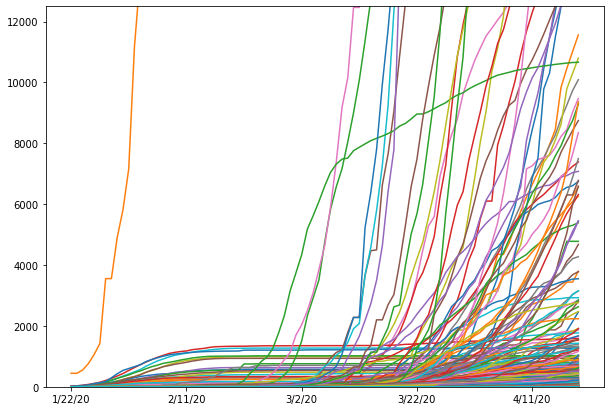

In [17]:
ntw,reg=fileClean(confirmed)
for i in range(len(ntw)):
    ntw.iloc[i].plot(ylim=(0,12500), figsize=(10,7))

- You can see that different regions have start dates that vary greatly in time. This will make comparing curves difficult. This is why I reset all times to zero. This also has the benefit on allowing regions that have been experiencing infection for longer than Canada to act as "windows into the future".

- Plot timewarped curves: 

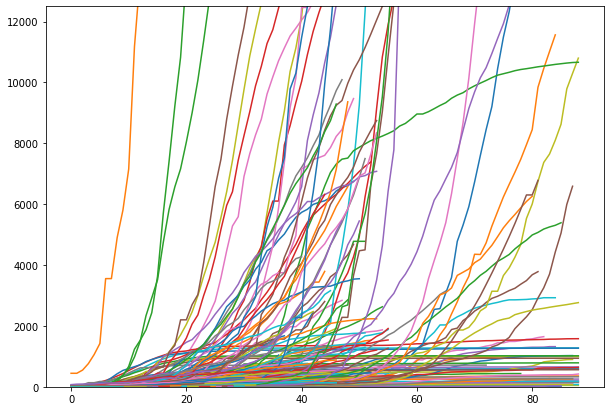

In [18]:
days=daysSinceFirst(ntw, reg)
for i in range(len(days)):
    days.iloc[i].plot(ylim=(0,12500), figsize=(10,7))

- We can see that it would make sense to set all countries first day of infection as their start point. Also see that this, in a sense, gives us a window into the future.

Plot of confirmed cases on most recent day of dataset:

The mean of cases on most recent day is: 9235.988461538462 , standard deviation is: 52492.94209505916


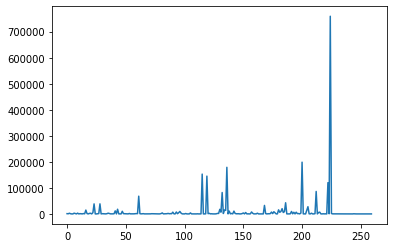

In [19]:
ntw.iloc[:,-1].plot()
print('The mean of cases on most recent day is:', ntw.iloc[:,-1].mean(), ', standard deviation is:', ntw.iloc[:,-1].std())

- We can see that magnitude varies widely. Thus we will see whether scaling the curves might make sense. 

Plot of scaled curves (not timewarped, but we will time-warp them during analysis):

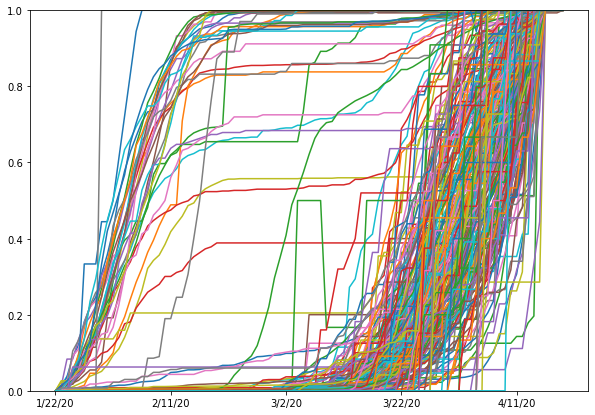

In [20]:
dem,rr=fileClean(confirmed)
sx,sy=splitXY(dem)
sx,sy,tm,tma=scaler(sx,sy)
dem=sx.join(sy)

for i in range(len(dem)):
    dem.iloc[i].plot(ylim=(0,1), figsize=(10,7))

- Can see that the curves are a lot more similar after scaling, so I opted to scale to allow the trajectories to be more comparable, and to enable clustering.

**My thought process in choosing a model:**

- I decided that, since we have so few datapoints, there was no need to perform any moving average smoothing or anything like that.

- After all of the above-mentioned data preparation, the most difficult thing was deciding how to model this data to make predictions into the future. Initially I had thought that treating it as a time series would be best, but I did not like the fact that most time series methods would simply predict future values based only on past values for the province in question. I wanted to be able to gain some predictive power from other regions who are ahead of us on the corona curve. Additionally, multivariate time series modelling didn't seem appropriate as an assumption of that type of model seems to be that all variables affect one another's current and future values. Other countries' curves do not affect Canada's curves in a direct way, but should merely act as a template for them going into the future. What I had ideally had in mind was some sort of transfer learning in conjunction with time series, but this seemed too complex. 

- I then thought that time series may be unnecessary anyway. Because these curves are for such a short period (a matter of months), and the fact that they are very consistent in their behaviour (all increasing over time), we do not need to worry about things like periodicity or seasonality; things that time series is useful for addressing. As such, I decided to not treat them like a time series, and to just use more traditional machine learning methods.

- However, it was still very challenging to know how to use the variables to predict the future values for each province. Initially I had an XGBoost model with just days as features with their scaled value, but the dimensionality vs number of rows was crazy. Eventually, I decided that using lagged variables would be my best bet, as then the province in question could have values for prediction on the day it was running for (when a feature is a variable with a 3 day lag, you can have values for this feature 3 days into the future).

- So I settled for a random forest regressor (see the predict function), and experiemnted with creating several lagged variables as features to regress against the actual number of cumulative cases for that day (the target). The random forest regressor performed better on my final dataset than did an xgboost regressor. I experiemnted with adding lagged features until the model ceased to increase in prediction accuracy. The features I created can be seen in the featureCreation function. Examples are: number of cases 3 days ago, number of cases 4 days ago, difference between number of cases 3 and 4 days ago. Different numbers of these features produced optimal performance for predicting 1, 2, and 3 days hence. The features in the model were only optimized on the confirmed cases dataset due to me running out of time. However, it's predictions for death and recovered seemed sensible. However, if I could address this problem again, I would like to include features that use some form of lagged confirmed cases for prediction in the deaths and recovered model, as the number of confirmed cases surely affects these outcomes and should add some predictive power.

- For this model, I trained on the subset of regions which have had infections for at least 3 days more than the focal province, with their lagged values as features and their actual number of cases per day as the ytrain variable. After training, I then use this model to predict for my province in question. This creates a prediction for every day; i.e. none of the raw values for the province are actually used in predicting the prediction day, however the actual values are still having an effect, just in the form of the lagged varaibles made above. I had tried to include prior days from the province in training to just predict the last day, but this resulted in ridiculous predictions, such as a drop in 60% of cases. I know random forest regressors have poor performance when extrapolating outside of their range, so I wonder if this is what was happenning here. 

- As was discussed above, I used trajectory clustering to remove outlier curves from my dataset. However, some provinces are, themselves, outliers. If I had more time, I would have liked to have tried time series modelling on these provinces as, since they are so unusual, their past values may be a better indicator of future behaviour than are other regions.

- I tuned the hyperparameters in my model via a cross-validated randomized search (code is in appendix). This model was only optimized for confirmed cases, but seemed to function well for the other datasets too.

**PREDICTIONS:** 

**Generate train and test data for predictions for confirmed cases:**

My preprocessing of the data was quite computationally expensive (calculating Frechet distances and clustering on the confirmed cases curves takes around 35 minutes). As such, I have exported the preprocessed data to CSVs. These will be handed in with the notebook and there is code to read them in below. As such, the following 2 code chunks in which I process the data and export it as CSVs have been commented out.

In [22]:
#Get train and test for all provinces and canada (hav 999 as canada code)
'''
train1=[]
train2=[]
train3=[]
test1=[]
test2=[]
test3=[]
mmins=[]
mmaxs=[]

for i in provIndex:
    datad, clusterd, mmind, mmaxd, idx = masterFunkConf(confirmed, i) #gets data for each province, as well as their cluster,... 
    for j in predDays:                                                  #min and max value for infection cases, and their index
        train, test=featureCreation(datad, j, idx)
        if j == 1:
            train1.append(train)
            test1.append(test)
        elif j == 2:
            train2.append(train)
            test2.append(test)
        elif j == 3:
            train3.append(train)
            test3.append(test)
    mmins.append(mmind)
    mmaxs.append(mmaxd)#'''

cluster for index 250 : 0
999
cluster for index 35 : 0
35
cluster for index 36 : -1
36
cluster for index 37 : -1
37
cluster for index 38 : -1
38
cluster for index 39 : 1
39
cluster for index 40 : 0
40
cluster for index 41 : -1
41
cluster for index 42 : 1
42
cluster for index 43 : 2
43
cluster for index 44 : -1
44


In [23]:
#Export train and test data for confirmed cases dataset:
'''
for i in range(len(provIndex)):
    export_csv = train1[i].to_csv (str(provIndex[i]) +'train1conf.csv', index = None, 
                               header=True)
    export_csv = train2[i].to_csv (str(provIndex[i]) +'train2conf.csv', index = None, 
                               header=True)
    export_csv = train3[i].to_csv (str(provIndex[i]) +'train3conf.csv', index = None, 
                               header=True)
    export_csv = test1[i].to_csv (str(provIndex[i]) +'test1conf.csv', index = None, 
                               header=True)
    export_csv = test2[i].to_csv (str(provIndex[i]) +'test2conf.csv', index = None, 
                               header=True)
    export_csv = test3[i].to_csv (str(provIndex[i]) +'test3conf.csv', index = None, 
                               header=True)
'''

**Generate predictions for confirmed cases:**

- First, set lists of province indexes in the dataframe, and for the future days we want to predict:

In [21]:
provName=['Canada','Alberta', 'British Columbia', 'Manitoba', 'New Brunswick', 'New Foundland and Labrador', 'Nova Scotia', 'Ontario', 
          'Prince Edward Island', 'Quebec', 'Saskatchewan']
provIndex=[999,35,36,37,38,39,40,41,42,43,44]
predDays=[1,2,3]

- The following chunk imports the train and test data generated by me earlier. I have hardcoded in the min and max values as these will not change after submission, and this means a couple of fewer CSVs are required to load in.

In [24]:
# To run models; import train and test data:
# Mins and Maxs have been hard-coded in so that you don't need to run the above functions

xtrain1=[]
xtrain2=[]
xtrain3=[]
xtest1=[]
xtest2=[]
xtest3=[]
xmmins=[77,1,1,4,1,1,5,1,1,1,2] #These are the max and min values needed to de-scale my prediction.
xmmaxs=[35606, 2803,1647,254,118,257,675,11561,26,17950,315]
#have hardcoded these in so that things will run with the CSVs i submitted

for i in range(len(provIndex)):
    tr1=pd.read_csv(str(provIndex[i]) + 'train1conf.csv')
    tr2=pd.read_csv(str(provIndex[i]) + 'train2conf.csv')
    tr3=pd.read_csv(str(provIndex[i]) + 'train3conf.csv')
    ts1=pd.read_csv(str(provIndex[i]) + 'test1conf.csv')
    ts2=pd.read_csv(str(provIndex[i]) + 'test2conf.csv')
    ts3=pd.read_csv(str(provIndex[i]) + 'test3conf.csv')
    
    xtrain1.append(tr1)
    xtrain2.append(tr2)
    xtrain3.append(tr3)
    xtest1.append(ts1)
    xtest2.append(ts2)
    xtest3.append(ts3)

- Loop to generate predictions for confirmed cases:
- This takes around 10-15 minutes to run, which I know is on the upper limit of your time-limit. I do apologize for this, but I use different datasets to train each prediction model, thus I would have needed to hand in a pickle file per model, in addition to all of the CSVs already handed in. 

In [25]:
#Takes 10-15 mins to run on my machine
confirmedPredictions=[]

for i in range(len(provIndex)):
    p1=predict(xtrain1[i], xtest1[i], xmmins[i], xmmaxs[i]) #min and max to de-scale predictions
    p2=predict(xtrain2[i], xtest2[i], xmmins[i], xmmaxs[i])
    p3=predict(xtrain3[i], xtest3[i], xmmins[i], xmmaxs[i])
    index=provIndex[i]
    maxx=xmmaxs[i]
    plist=[index, maxx, p1, p2, p3]
    confirmedPredictions.append(plist)
    print(plist)

[999, 35606, 36433.0, 38869.0, 41379.0]
[35, 2803, 3059.0, 3323.0, 3525.0]
[36, 1647, 1660.0, 1664.0, 1700.0]
[37, 254, 271.0, 259.0, 264.0]
[38, 118, 119.0, 120.0, 120.0]
[39, 257, 259.0, 258.0, 260.0]
[40, 675, 707.0, 731.0, 773.0]
[41, 11561, 12090.0, 12487.0, 13581.0]
[42, 26, 26.0, 26.0, 26.0]
[43, 17950, 19064.0, 18964.0, 19717.0]
[44, 315, 322.0, 333.0, 334.0]


- Final prediction dataframe for confirmed cases:  

In [26]:
confirmedPredictionsdf=pd.DataFrame(confirmedPredictions)

In [27]:
confirmedPredictionsdf=confirmedPredictionsdf.drop(0, axis=1)
provinces=pd.DataFrame(provName)
confirmed_predicted=provinces.join(confirmedPredictionsdf)
confirmed_predicted.columns=['Region', 'April 19', 'April 20', 'April 21', 'April 22']
confirmed_predicted=confirmed_predicted.drop('April 19', axis=1)

In [28]:
confirmed_predicted

,Region,April 20,April 21,April 22
0,Canada,36433.0,38869.0,41379.0
1,Alberta,3059.0,3323.0,3525.0
2,British Columbia,1660.0,1664.0,1700.0
3,Manitoba,271.0,259.0,264.0
4,New Brunswick,119.0,120.0,120.0
5,New Foundland and Labrador,259.0,258.0,260.0
6,Nova Scotia,707.0,731.0,773.0
7,Ontario,12090.0,12487.0,13581.0
8,Prince Edward Island,26.0,26.0,26.0
9,Quebec,19064.0,18964.0,19717.0


In [29]:
export_csv = confirmed_predicted.to_csv ('confirmed_predicted.csv', index = None, 
                               header=True)

**Generate predictions for deaths:**

- Initialize lists of provinces. These have different indexes as many rows have to be removed from death due to null values 

In [30]:
provNameDeath=['Canada','Alberta', 'British Columbia', 'Manitoba', 'New Foundland and Labrador', 'Nova Scotia', 'Ontario', 
          'Prince Edward Island', 'Quebec', 'Saskatchewan']
provIndexDeath=[999, 32,33,34,35,36,37,38,39,40,]

- Generate train and test data for all 3 days:
- This takes a much shorter time than for confirmed cases, thus I have let it run in my final notebook. It takes around 5 minutes.

In [31]:
train1d=[]
train2d=[]
train3d=[]
test1d=[]
test2d=[]
test3d=[]
mminsd=[]
mmaxsd=[]

for i in provIndexDeath:
    data, cluster, mmin, mmax, idx = masterFunkDeath(death, i) #data for each province in list
    for j in predDays:
        train, test=featureCreation(data, j, idx)
        if j == 1:
            train1d.append(train)
            test1d.append(test)
        elif j == 2:
            train2d.append(train)
            test2d.append(test)
        elif j == 3:
            train3d.append(train)
            test3d.append(test)
    mminsd.append(mmin)
    mmaxsd.append(mmax)

cluster for index 196 : 0
cluster for index 32 : 0
cluster for index 33 : 0
cluster for index 34 : -1
cluster for index 35 : -1
cluster for index 36 : -1
cluster for index 37 : 0
cluster for index 38 : -1
cluster for index 39 : 0
cluster for index 40 : -1


- Now use the train and test data to make predictions:
- This takes less than 5 minutes to run.

In [32]:
deathPredictions=[]

for i in range(len(provIndexDeath)):
    p1=predict(train1d[i], test1d[i], mminsd[i], mmaxsd[i])
    p2=predict(train2d[i], test2d[i], mminsd[i], mmaxsd[i])
    p3=predict(train3d[i], test3d[i], mminsd[i], mmaxsd[i])
    index=provIndexDeath[i]
    maxx=mmaxsd[i]
    plist=[index, maxx.values[0], p1.values[0], p2.values[0], p3.values[0]]
    deathPredictions.append(plist)
    if i==3:
        nblist=[0,0,0,0,0] #row for new brunswick
        deathPredictions.append(nblist)
    print(plist)

[999, 1564.0, 1657.0, 1727.0, 1784.0]
[32, 51.0, 54.0, 56.0, 59.0]
[33, 81.0, 83.0, 84.0, 86.0]
[34, 5.0, 5.0, 5.0, 5.0]
[35, 3.0, 3.0, 3.0, 3.0]
[36, 9.0, 9.0, 15.0, 16.0]
[37, 591.0, 609.0, 653.0, 719.0]
[38, 1.0, 1.0, 1.0, 1.0]
[39, 820.0, 946.0, 917.0, 1012.0]
[40, 4.0, 4.0, 4.0, 4.0]


In [33]:
deathPredictionsdf=pd.DataFrame(deathPredictions)

In [34]:
deathPredictionsdf=deathPredictionsdf.drop(0, axis=1)
provincesd=pd.DataFrame(provName)
deaths_predicted=provinces.join(deathPredictionsdf)
deaths_predicted.columns=['Region', 'April 19', 'April 20', 'April 21', 'April 22']
deaths_predicted=deaths_predicted.drop('April 19', axis=1)

In [35]:
deaths_predicted

,Region,April 20,April 21,April 22
0,Canada,1657.0,1727.0,1784.0
1,Alberta,54.0,56.0,59.0
2,British Columbia,83.0,84.0,86.0
3,Manitoba,5.0,5.0,5.0
4,New Brunswick,0.0,0.0,0.0
5,New Foundland and Labrador,3.0,3.0,3.0
6,Nova Scotia,9.0,15.0,16.0
7,Ontario,609.0,653.0,719.0
8,Prince Edward Island,1.0,1.0,1.0
9,Quebec,946.0,917.0,1012.0


In [36]:
export_csv = deaths_predicted.to_csv ('deaths_predicted.csv', index = None, 
                               header=True)

**Generate predictions for recovered cases:**

In [37]:
# Canada is index 36 in the dataframe after null rows are removed. I have just hard-coded this value in for simplicity.

train1r=[]
train2r=[]
train3r=[]
test1r=[]
test2r=[]
test3r=[]
mminsr=[]
mmaxsr=[]


rdata, rcluster, rmmin, rmmax, ridx = masterFunkDeath(rec,36)
mminsr.append(rmmin)
mmaxsr.append(rmmax)
for j in predDays:
    train, test=featureCreation(rdata, j, ridx)
    if j == 1:
        train1r.append(train)
        test1r.append(test)
    elif j == 2:
        train2r.append(train)
        test2r.append(test)
    elif j == 3:
        train3r.append(train)
        test3r.append(test)

cluster for index 36 : -1


In [38]:
recPredictions=[]

p1r=predict(train1r[0], test1r[0], mminsr[0], mmaxsr[0])
p2r=predict(train2r[0], test2r[0], mminsr[0], mmaxsr[0])
p3r=predict(train3r[0], test3r[0], mminsr[0], mmaxsr[0])
indexr=36
maxxr=mmaxsr[0]
plistr=[indexr, maxxr.values[0], p1r.values[0], p2r.values[0], p3r.values[0]]
recPredictions.append(plistr)

In [39]:
recPredictionsdf=pd.DataFrame(recPredictions)

In [40]:
canLabel=['Canada']
recPredictionsdf=recPredictionsdf.drop(0, axis=1)
provincesr=pd.DataFrame(canLabel)
recovered_predicted=provincesr.join(recPredictionsdf)
recovered_predicted.columns=['Region', 'April 19', 'April 20', 'April 21', 'April 22']
recovered_predicted=recovered_predicted.drop('April 19', axis=1)

In [41]:
recovered_predicted

,Region,April 20,April 21,April 22
0,Canada,12564.0,12655.0,13508.0


In [42]:
export_csv = recovered_predicted.to_csv ('recovered_predicted.csv', index = None, 
                               header=True)

Appendix:

In [726]:
#Random search used to train models:
#Had to settle for random search rather than grid search due to time constraints

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, n_iter = 100, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1)

In [ ]:

#validate model based on deaths and recovered.
#add confirmed cases as features to these too.
#clean  up functions
#why did PEI have a case?